# Stochastic Optimization

## Exercise on Control

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a>&nbsp;| Dennis G. Wilson | <a href="https://supaerodatascience.github.io/stochastic/">https://supaerodatascience.github.io/stochastic/</a>

### **NAMES** : Paul Laisné, Niels Albrecht

Today you'll explore advanced SGD methods (momentum, Adam) and compare them with gradient-free approaches on a robotic arm control problem. You'll also learn automatic differentiation with JAX.

In [1]:
# Setup and Imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import jax
import jax.numpy as jnp
from jax import grad, jit
from typing import Tuple, List, Callable
import time

# Set random seeds for reproducibility
np.random.seed(42)

# Enable JAX to run on CPU (for consistent behavior across platforms)
jax.config.update('jax_platform_name', 'cpu')

print("Setup complete! JAX version:", jax.__version__)
print("NumPy version:", np.__version__)

Setup complete! JAX version: 0.4.35
NumPy version: 2.2.5


# Exploring the Robot Arm
Run the provided visualization to understand the 2-joint planar arm. Experiment with different joint angles. We will experiment with two different libraries for this robot arm: numpy and [jax](docs.jax.dev/en/latest/index.html). Jax will enable easier gradient calculations through [automatic differentiation](https://huggingface.co/blog/andmholm/what-is-automatic-differentiation). For now, understand and explore this 2-joint robot arm which uses two angles to calculate the end position of the arm.

In [2]:
def forward_kinematics_numpy(theta: np.ndarray, lengths: np.ndarray) -> np.ndarray:
    """
    Compute end-effector position for a 2-joint planar arm.
    
    Parameters:
    -----------
    theta : np.ndarray, shape (2,)
        Joint angles [theta1, theta2] in radians
    lengths : np.ndarray, shape (2,)
        Link lengths [L1, L2]
    
    Returns:
    --------
    position : np.ndarray, shape (2,)
        End-effector position [x, y]
    """
    theta1, theta2 = theta
    L1, L2 = lengths
    
    # First joint position
    x1 = L1 * np.cos(theta1)
    y1 = L1 * np.sin(theta1)
    
    # End-effector position
    x2 = x1 + L2 * np.cos(theta1 + theta2)
    y2 = y1 + L2 * np.sin(theta1 + theta2)
    
    return np.array([x2, y2])

In [3]:
# JAX version (for automatic differentiation)
def forward_kinematics_jax(theta: jnp.ndarray, lengths: jnp.ndarray) -> jnp.ndarray:
    """
    Compute end-effector position for a 2-joint planar arm (JAX version).
    
    Parameters:
    -----------
    theta : jnp.ndarray, shape (2,)
        Joint angles [theta1, theta2] in radians
    lengths : jnp.ndarray, shape (2,)
        Link lengths [L1, L2]
    
    Returns:
    --------
    position : jnp.ndarray, shape (2,)
        End-effector position [x, y]
    """
    theta1, theta2 = theta
    L1, L2 = lengths
    
    # First joint position
    x1 = L1 * jnp.cos(theta1)
    y1 = L1 * jnp.sin(theta1)
    
    # End-effector position
    x2 = x1 + L2 * jnp.cos(theta1 + theta2)
    y2 = y1 + L2 * jnp.sin(theta1 + theta2)
    
    return jnp.array([x2, y2])

In [4]:
# Get all joint positions for visualization
def get_arm_points(theta: np.ndarray, lengths: np.ndarray) -> np.ndarray:
    """
    Get positions of all joints for visualization.
    
    Returns:
    --------
    points : np.ndarray, shape (3, 2)
        Positions of [base, joint1, end-effector]
    """
    theta1, theta2 = theta
    L1, L2 = lengths
    
    # Base at origin
    p0 = np.array([0.0, 0.0])
    
    # First joint
    p1 = np.array([L1 * np.cos(theta1), L1 * np.sin(theta1)])
    
    # End-effector
    p2 = p1 + np.array([L2 * np.cos(theta1 + theta2), 
                        L2 * np.sin(theta1 + theta2)])
    
    return np.array([p0, p1, p2])

In [5]:
# Test the implementations
print("Testing forward kinematics...")
test_theta = np.array([np.pi/4, np.pi/4])
test_lengths = np.array([1.0, 1.0])

pos_numpy = forward_kinematics_numpy(test_theta, test_lengths)
pos_jax = forward_kinematics_jax(test_theta, test_lengths)

print(f"NumPy result: {pos_numpy}")
print(f"JAX result: {pos_jax}")
print(f"Match: {np.allclose(pos_numpy, np.array(pos_jax))}")

Testing forward kinematics...
NumPy result: [0.70710678 1.70710678]
JAX result: [0.7071067 1.7071068]
Match: True


In [6]:
# Visualization Utilities
def plot_arm(theta: np.ndarray, lengths: np.ndarray, 
             target: np.ndarray = None, obstacles: List = None,
             ax=None, title: str = "Robot Arm"):
    """
    Plot the robot arm configuration.
    
    Parameters:
    -----------
    theta : np.ndarray
        Joint angles
    lengths : np.ndarray
        Link lengths
    target : np.ndarray, optional
        Target position to visualize
    obstacles : List of tuples, optional
        List of (x, y, radius) for circular obstacles
    ax : matplotlib axis, optional
        Axis to plot on
    title : str
        Plot title
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    # Get arm points
    points = get_arm_points(theta, lengths)
    
    # Plot arm links
    ax.plot(points[:, 0], points[:, 1], 'o-', linewidth=3, 
            markersize=8, label='Arm', color='blue')
    
    # Plot base
    ax.plot(0, 0, 'ks', markersize=12, label='Base')
    
    # Plot end-effector
    ax.plot(points[-1, 0], points[-1, 1], 'ro', 
            markersize=10, label='End-effector')
    
    # Plot target if provided
    if target is not None:
        ax.plot(target[0], target[1], 'g*', 
                markersize=15, label='Target')
    
    # Plot obstacles if provided
    if obstacles is not None:
        for obs in obstacles:
            circle = Circle((obs[0], obs[1]), obs[2], 
                          color='red', alpha=0.3, label='Obstacle')
            ax.add_patch(circle)
    
    # Set axis properties
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-2.5, 2.5)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(title)
    ax.legend()

    
    return ax

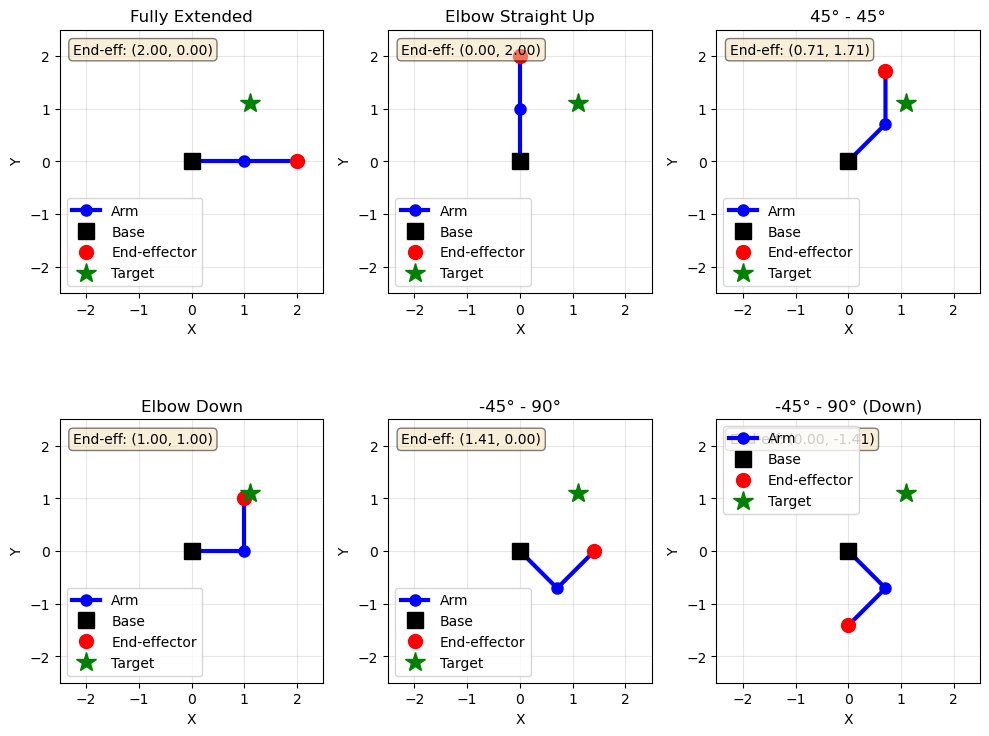

In [7]:
# Standard link lengths we'll use throughout
LENGTHS = np.array([1.0, 1.0])

# Example: Visualize different arm configurations
fig, axes = plt.subplots(2, 3, figsize=(10, 8))
axes = axes.flatten()

# Some configurations
example_configs = [
    (np.array([0.0, 0.0]), "Fully Extended"),
    (np.array([np.pi/2, 0.0]), "Elbow Straight Up"),
    (np.array([np.pi/4, np.pi/4]), "45° - 45°"),
    (np.array([0.0, np.pi/2]), "Elbow Down"),
    (np.array([-np.pi/4, np.pi/2]), "-45° - 90°"),
    (np.array([-np.pi/4, -np.pi/2]), "-45° - 90° (Down)")
]

target = np.array([1.1, 1.1])
for i, (theta, title) in enumerate(example_configs):
    plot_arm(theta, LENGTHS, target=target, ax=axes[i], title=title)
    end_eff = forward_kinematics_numpy(theta, LENGTHS)
    axes[i].text(0.05, 0.95, f'End-eff: ({end_eff[0]:.2f}, {end_eff[1]:.2f})',
                transform=axes[i].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

<div class="alert alert-info">
Q1: The robot arm has multiple solutions to reach the same point (elbow-up vs elbow-down configurations). Using the provided forward_kinematics function, find two different joint angle configurations θ = [θ₁, θ₂] that place the end-effector at approximately (1.1, 1.1). What does this tell you about the optimization landscape?
</div>

**A1** : To find two different joint angle configurations that place the end-effector at approximately (1.1, 1.1), we can use the forward_kinematics function to calculate the end position of the arm for various joint angles.
To implement this, we can iterate through a range of joint angles and check if the resulting end position is close to (1.1, 1.1).

We will iterate through the following grid configurations:
- $\theta_1 \in [-\pi, \pi]$ with 1000 samples
- $\theta_2 \in [-\pi, \pi]$ with 1000 samples

To check if the resulting end position is close to (1.1, 1.1), we can use a small tolerance value (e.g., $1e-5$) to determine if the distance between the calculated end position and the target position is within this tolerance.


In [8]:
theta1_list = np.linspace(-np.pi, np.pi, 1000)
theta2_list = np.linspace(-np.pi, np.pi, 1000)
target = np.array([1.1, 1.1])
valid_pos = []
end_eff_pos = []
tol = 1e-5
best_pos = np.array([0.0, 0.0])
best_distance = np.sum((target - best_pos) ** 2)

for theta1 in theta1_list:
    for theta2 in theta2_list:
        theta = np.array([theta1, theta2])
        end_pos = forward_kinematics_numpy(theta, LENGTHS)
        # use elementwise power and sum to get squared distance
        if np.sum((end_pos - target) ** 2) < tol:
            valid_pos.append(theta)
            end_eff_pos.append(end_pos)
        if np.sum((end_pos - target) ** 2) < best_distance:
            best_pos = theta
            best_distance = np.sum((end_pos - target) ** 2)

valid_pos = np.array(valid_pos)
end_eff_pos = np.array(end_eff_pos)

print("Valid positions:")
for pos in valid_pos:
    print("Theta1: {:.4f}, Theta2: {:.4f}".format(pos[0], pos[1]))
print("End_effector corresponding positions:")
for pos in end_eff_pos:
    print("X: {:.4f}, Y: {:.4f}".format(pos[0], pos[1]))

print(f"Best position found: Theta1: {best_pos[0]:.4f}, Theta2: {best_pos[1]:.4f}")


Valid positions:
Theta1: 0.1038, Theta2: 1.3617
Theta1: 1.4623, Theta2: -1.3554
End_effector corresponding positions:
X: 1.0998, Y: 1.0980
X: 1.1026, Y: 1.1008
Best position found: Theta1: 0.1038, Theta2: 1.3617


By chance, we found exactly with this method 2 configurations that satisfy this condition ! We will now visualize them below.

0
1


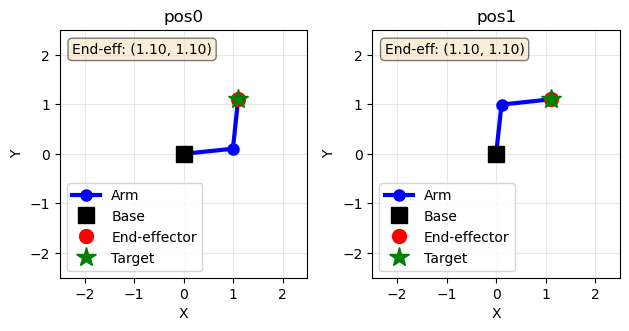

In [9]:
fig, axes = plt.subplots(len(valid_pos)//2 if len(valid_pos) % 2 == 0 else len(valid_pos)//2 + 1, 2)
axes = axes.flatten()

for i, theta in enumerate(valid_pos):
    print(i)
    plot_arm(theta, LENGTHS, target=target, ax=axes[i], title=f"pos{i}")
    end_eff = forward_kinematics_numpy(theta, LENGTHS)
    axes[i].text(0.05, 0.95, f'End-eff: ({end_eff[0]:.2f}, {end_eff[1]:.2f})',
                transform=axes[i].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

We can see that for any given target position inside the reachable workspace of the robot arm, there are typically two distinct joint angle configurations (elbow-up and elbow-down) that can achieve the same end-effector position. This indicates that the optimization landscape has multiple local minima corresponding to these different configurations. 

For the particular position where $\theta_2 = 0$, there is only one configuration (fully extended arm), which represents a unique solution in the optimization landscape.

## Part 1: Automatic Differentiation

Instead of guessing at the angles for a target, we will calculate them exactly. Use the provided JAX implementation to compute gradients of the loss function with respect to joint angles.

In [10]:
# Loss Functions
def loss_target_reaching(theta: jnp.ndarray, lengths: jnp.ndarray, 
                        target: jnp.ndarray) -> float:
    """
    Loss for reaching a target position.
    
    L = ||end_effector(theta) - target||^2
    
    Parameters:
    -----------
    theta : jnp.ndarray, shape (2,)
        Joint angles
    lengths : jnp.ndarray, shape (2,)
        Link lengths
    target : jnp.ndarray, shape (2,)
        Target position
    
    Returns:
    --------
    loss : float
        Squared distance to target
    """
    end_effector = forward_kinematics_jax(theta, lengths)
    return jnp.sum((end_effector - target) ** 2)

In [11]:
# Create JIT-compiled versions for speed
loss_target_reaching_jit = jit(loss_target_reaching)
print(loss_target_reaching)
print(loss_target_reaching_jit)

<function loss_target_reaching at 0x322b77c70>
<PjitFunction of <function loss_target_reaching at 0x322b77c70>>


In [12]:
# Create gradient functions
grad_loss_target = jit(grad(loss_target_reaching, argnums=0))

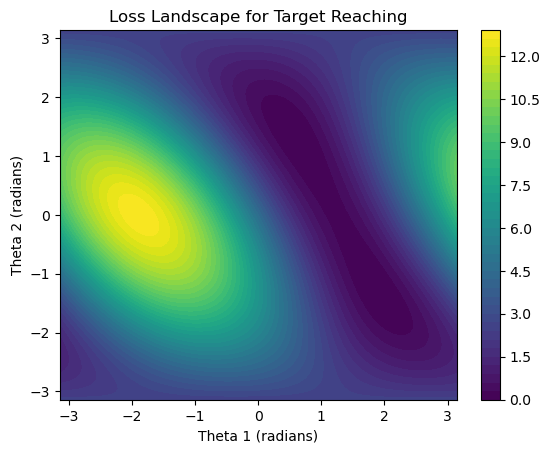

In [54]:
# Plot some loss landscapes
theta1_vals = jnp.linspace(-jnp.pi, jnp.pi, 100)
theta2_vals = jnp.linspace(-jnp.pi, jnp.pi, 100)
Theta1, Theta2 = jnp.meshgrid(theta1_vals, theta2_vals)
target = jnp.array([0.5, 1.5])
Loss_vals = jnp.zeros(Theta1.shape)
for i in range(Theta1.shape[0]):
    for j in range(Theta1.shape[1]):
        theta = jnp.array([Theta1[i, j], Theta2[i, j]])
        Loss_vals = Loss_vals.at[i, j].set(loss_target_reaching_jit(theta, LENGTHS, target))

# Plot loss landscape
plt.figure()
cp = plt.contourf(Theta1, Theta2, Loss_vals, levels=50, cmap='viridis')
plt.colorbar(cp)
plt.xlabel('Theta 1 (radians)')
plt.ylabel('Theta 2 (radians)')
plt.title('Loss Landscape for Target Reaching')
plt.show()

In [14]:
# Test the loss functions
print("Testing loss functions...")
test_theta = jnp.array([0.5, 0.5])
test_lengths = jnp.array([1.0, 1.0])
test_target = jnp.array([1.0, 1.0])

loss_val = loss_target_reaching(test_theta, test_lengths, test_target)
print(f"Loss value: {loss_val:.4f}")

grad_val = grad_loss_target(test_theta, test_lengths, test_target)
print(f"Gradient: {grad_val}")

Testing loss functions...
Loss value: 0.2776
Gradient: [-0.19397663 -0.35651365]


<div class="alert alert-info">
Q2: Compute the gradient using JAX autodiff at $θ=[π/6, π/4]$
Then verify it matches a manual finite-difference approximation:

For finite differences, use:
  $∂L/∂θᵢ ≈ (L(θ + h*eᵢ) - L(θ - h*eᵢ)) / (2h)$
  where $eᵢ$ is the i-th unit vector and $h = 1e-5$
</div>

In [15]:
test_theta = jnp.array([np.pi/6, np.pi/4])
grad_val_jax =grad_loss_target(test_theta, test_lengths, test_target)
h = 1e-5
finit_diff_approx_1 = (loss_target_reaching(test_theta + np.array([h, 0]), test_lengths, test_target) - loss_target_reaching(test_theta - np.array([h, 0]), test_lengths, test_target))/(2*h)
finit_diff_approx_2 = (loss_target_reaching(test_theta + np.array([0, h]), test_lengths, test_target) - loss_target_reaching(test_theta - np.array([0, h]), test_lengths, test_target))/(2*h)
finit_diff_approx = np.array([finit_diff_approx_1, finit_diff_approx_2])
print(grad_val_jax)
print(finit_diff_approx)
print(f"Match: {np.allclose(finit_diff_approx, np.array(grad_val_jax))} ")


[6.8216276e-01 5.2615547e-08]
[ 0.6839633  -0.00149012]
Match: False 


<div class="alert alert-info">
Q3: Compare the computational time of evaluating the gradient using JAX autodiff versus evaluating just the forward pass (loss calculation only). Run each 1000 times and report the ratio. What does this tell you about the computational overhead of automatic differentiation?</div>

In [16]:
start = time.perf_counter()
for _ in range(10000):
    grad_loss_target(test_theta, test_lengths, test_target)
duration_autodiff = (time.perf_counter() - start)

start = time.perf_counter()
for _ in range(10000):
    loss_target_reaching(test_theta, test_lengths, test_target)
duration_loss = (time.perf_counter() - start)

start = time.perf_counter()
for _ in range(10000):
    loss_target_reaching_jit(test_theta, test_lengths, test_target)
duration_loss_jit = (time.perf_counter() - start)

print(duration_autodiff)
print(duration_loss)
print(duration_loss_jit)

0.05138904200066463
3.159577124999487
0.0502461249998305


## Part 2: Gradient Descent

Gradient Descent (GD) is the foundational optimization algorithm that iteratively moves parameters in the direction of steepest descent:
$\theta_{t+1} = \theta_t - \eta \nabla L(\theta_t)$

While conceptually simple, GD can be sensitive to the learning rate $η$ and may struggle with saddle points or narrow valleys in the loss landscape where the gradient direction changes rapidly.

For this exercise, implement basic gradient descent to move the robot arm to a target position.

In [17]:
def gradient_descent(theta_init: np.ndarray, 
                     target: np.ndarray,
                     lengths: np.ndarray,
                     learning_rate: float = 0.01,
                     n_iterations: int = 500,
                     lambda_obs: float = 10.0) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    # Convert to JAX arrays
    theta = jnp.array(theta_init)
    lengths_jax = jnp.array(lengths)
    target_jax = jnp.array(target)
    reach_iter = np.inf
    

    loss_fn = lambda th: loss_target_reaching(th, lengths_jax, target_jax)
    grad_fn = grad_loss_target

    # Storage for history
    theta_history = np.zeros((n_iterations + 1, 2))
    loss_history = np.zeros(n_iterations + 1)
    ee_trajectory = np.zeros((n_iterations + 1, 2))
    
    # Initial values
    theta_history[0] = np.array(theta)
    loss_history[0] = float(loss_fn(theta))
    ee_trajectory[0] = np.array(forward_kinematics_jax(theta, lengths_jax))
    
    # Optimization loop
    for i in range(n_iterations):
        # TODO: Compute gradient
        # gradient = ?
        grad = grad_fn(theta, lengths_jax, target_jax)
        # TODO: Update 
        # theta using gradient descent rule
        # theta = ?
        theta = theta - learning_rate * grad
        # Store history
        theta_history[i + 1] = np.array(theta)        
        loss_history[i + 1] = float(loss_fn(theta))        
        ee_trajectory[i + 1] = np.array(forward_kinematics_jax(theta, lengths_jax))
        if reach_iter > 1000:
            if np.sqrt(np.sum((ee_trajectory[i + 1] - target_jax)**2)) < 1e-2:
                reach_iter = i + 1
    
    return theta_history, loss_history, ee_trajectory, reach_iter

<div class="alert alert-info">
Q4: Run GD with learning rates $η = [0.001, 0.01, 0.1, 0.5, 1.0]$ for 500 iterations each, starting from $θ₀ = [0.1, 0.1]$ targeting (0.5, 1.5). Plot the loss curves. At what learning rate do you observe divergence? Explain what's happening in terms of the gradient descent update rule.
</div>

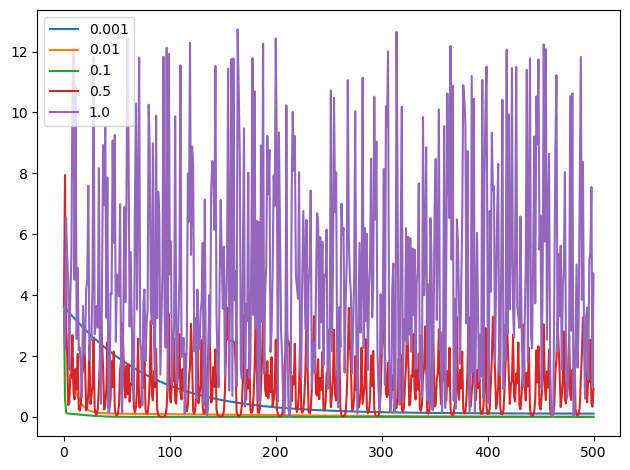

In [18]:
learning_rate = [1e-3, 1e-2, 0.1, 0.5, 1.0]
n_iter = 500
theta0 = np.array([0.1, 0.1])
target = np.array([0.5, 1.5])
histories = {}
for lr in learning_rate:
    histories[lr] = gradient_descent(theta0, target, LENGTHS, lr, n_iter)

plt.figure()
for lr in learning_rate:
    plt.plot(histories[lr][1], label=f"{lr}")

plt.legend()
plt.tight_layout()
plt.show()


<div class="alert alert-info">
Q5: For $η = 0.01$, plot the end-effector trajectory in 2D space (not the loss, but the actual path the end-effector takes). Does it take the most direct path to the target? Why or why not? (Hint: think about parameter space vs task space)
</div>

[[1.97507071 0.29850274]
 [1.94728565 0.43744093]
 [1.91091752 0.56876653]
 ...
 [0.51202279 1.56993914]
 [0.51195657 1.56959105]
 [0.51189065 1.56924427]]


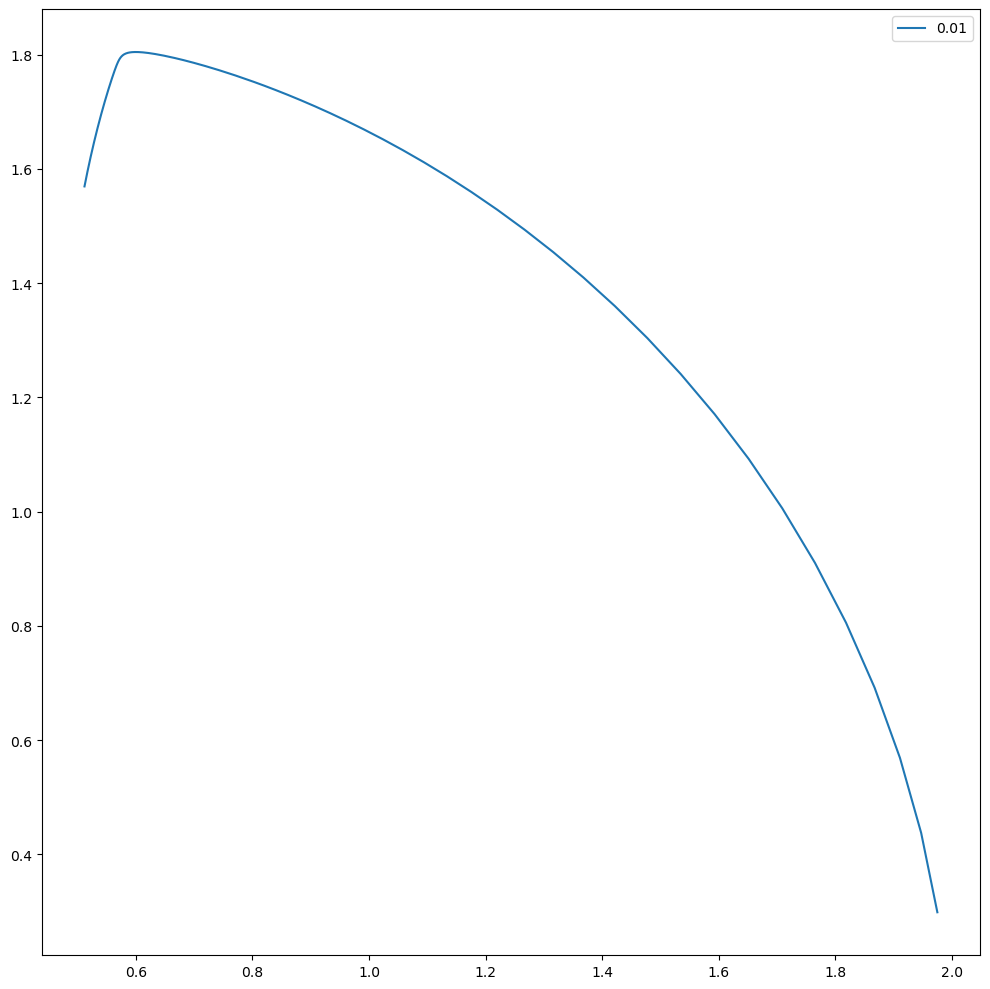

In [19]:
lr = 0.01
print(histories[lr][2])
plt.figure(figsize=(10,10))
plt.plot(histories[lr][2][:, 0], histories[lr][2][:, 1], label=f"{lr}")

plt.legend()
plt.tight_layout()
plt.show()

In [20]:
def animate_robot(history):
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Normalize input: accept dict (histories), tuple/list (history tuple), or raw theta_history array
    if isinstance(history, dict):
        first = next(iter(history.values()))
        theta_hist = first[0] if isinstance(first, (list, tuple)) else first
    elif isinstance(history, (list, tuple)):
        theta_hist = history[0]
    else:
        theta_hist = history

    def update(frame):
        ax.clear()
        theta = theta_hist[frame]
        plot_arm(theta, LENGTHS, target=target, ax=ax, title=f"Iteration {frame}")
        print(f"Frame {frame}: Theta = {theta}, End-effector = {forward_kinematics_numpy(theta, LENGTHS)}")

    ani = FuncAnimation(fig, update, frames=len(theta_hist), interval=100)
    plt.close(fig)
    return ani


In [ ]:
# Run animation
ani = animate_robot(histories[lr])

HTML(ani.to_jshtml())

## 2.2: SGD with Momentum

Momentum adds "inertia" to gradient descent by accumulating a velocity vector that combines the current gradient with previous gradients: $_t = \beta v_{t-1} + \nabla L(\theta_t)$
, then $\theta_{t+1} = \theta_t - \eta v_t$. This helps the optimizer build up speed in consistent directions and dampens oscillations in directions where gradients frequently change sign, allowing it to better navigate ravines and escape shallow local minima.


For this exercise, implement momentum-based gradient descent using the update rules:

$v_t = βv_{t-1} + ∇L(θ_t)$

$θ_{t+1} = θ_t - ηv_t$

In [22]:
def SGD(theta_init: np.ndarray, 
                     target: np.ndarray,
                     lengths: np.ndarray,
                     learning_rate: float = 0.01,
                     n_iterations: int = 500,
                     beta: float = 0.9,
                     lambda_obs: float = 10.0) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    # Convert to JAX arrays
    theta = jnp.array(theta_init)
    lengths_jax = jnp.array(lengths)
    target_jax = jnp.array(target)
    v = jnp.array([0, 0])
    reach_iter = np.inf

    loss_fn = lambda th: loss_target_reaching(th, lengths_jax, target_jax)
    grad_fn = grad_loss_target

    # Storage for history
    theta_history = np.zeros((n_iterations + 1, 2))
    loss_history = np.zeros(n_iterations + 1)
    ee_trajectory = np.zeros((n_iterations + 1, 2))
    v_history = np.zeros((n_iterations + 1, 2))
    
    # Initial values
    theta_history[0] = np.array(theta)
    loss_history[0] = float(loss_fn(theta))
    ee_trajectory[0] = np.array(forward_kinematics_jax(theta, lengths_jax))
    v_history[0] = np.array(v)
    
    # Optimization loop
    for i in range(n_iterations):
        # TODO: Compute gradient
        # gradient = ?
        grad = grad_fn(theta, lengths_jax, target_jax)
        v = beta * v + grad
        # TODO: Update 
        # theta using gradient descent rule
        # theta = ?
        theta = theta - learning_rate * v
        # Store history
        theta_history[i + 1] = np.array(theta)        
        loss_history[i + 1] = float(loss_fn(theta))        
        ee_trajectory[i + 1] = np.array(forward_kinematics_jax(theta, lengths_jax))
        v_history[i+1] = np.array(v)
        if reach_iter > 1000:
            if np.sqrt(np.sum((ee_trajectory[i + 1] - target_jax)**2)) < 1e-2:
                reach_iter = i + 1

    return theta_history, loss_history, ee_trajectory, v_history, reach_iter

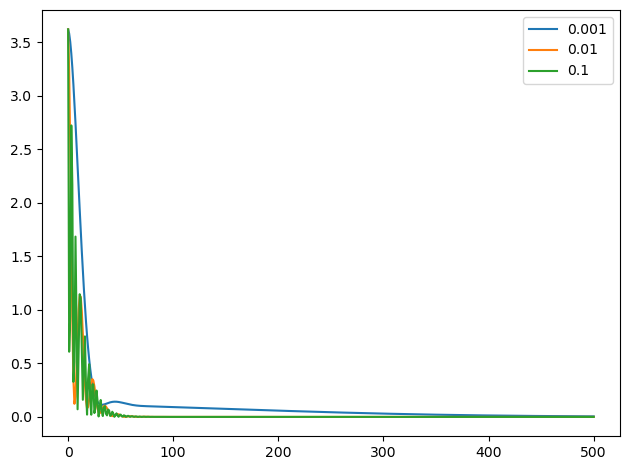

In [23]:
learning_rate = [1e-3, 1e-2, 0.1]
n_iter = 500
theta0 = np.array([0.1, 0.1])
target = np.array([0.5, 1.5])
histories_sgd = {}
for lr in learning_rate:
    histories_sgd[lr] = SGD(theta0, target, LENGTHS, lr, n_iter)

plt.figure()
for lr in learning_rate:
    plt.plot(histories_sgd[lr][1], label=f"{lr}")

plt.legend()
plt.tight_layout()
plt.show()

<div class="alert alert-info">
Q6: Compare GD vs Momentum ($β=0.9$) on the same task ($η=0.01$, target (0.5, 1.5)). Plot both the loss curves and the end-effector trajectories side-by-side. Describe one specific, concrete difference in how the arm moves with momentum versus without.
</div>
<div class="alert alert-info">
Q7: Track and plot the magnitude of the velocity vector $||v_t||$ over iterations for the momentum optimizer. What happens to this magnitude as the arm approaches the target? Explain why this behavior occurs.
</div>

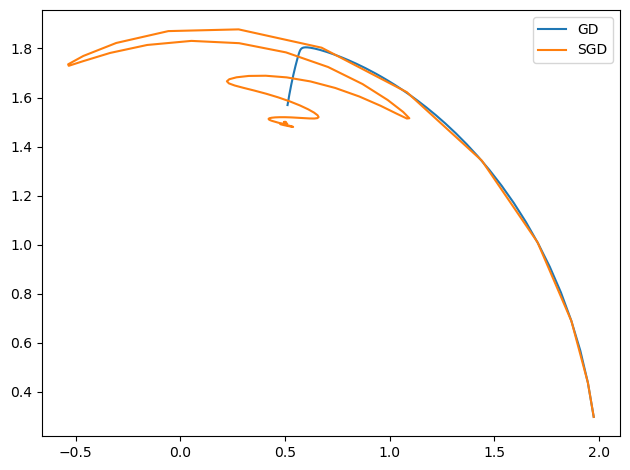

In [24]:
lr = 0.01
plt.figure()
plt.plot(histories[lr][2][:, 0], histories[lr][2][:, 1], label=f"GD")
plt.plot(histories_sgd[lr][2][:, 0], histories_sgd[lr][2][:, 1], label=f"SGD")


plt.legend()
plt.tight_layout()
plt.show()

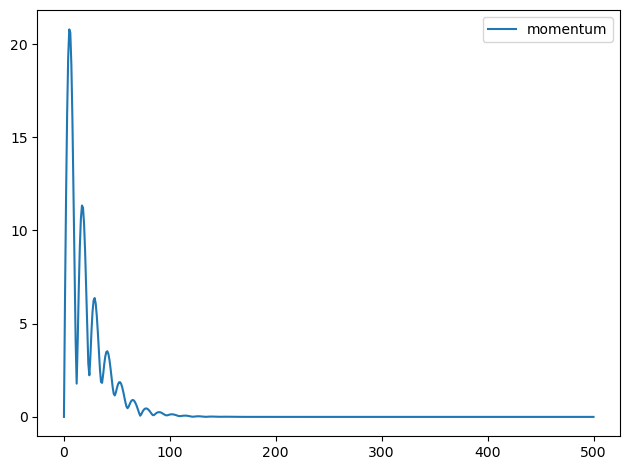

In [25]:
lr = 0.01
v_norm = np.linalg.norm(histories_sgd[lr][3], axis=1)
plt.figure()
plt.plot(v_norm, label=f"momentum")


plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Run animation
ani = animate_robot(histories_sgd[lr])

HTML(ani.to_jshtml())

## 2.3: Adam Optimizer

Adam (Adaptive Moment Estimation) combines ideas from momentum and adaptive learning rates by maintaining both a moving average of gradients (first moment $m_t$) and a moving average of squared gradients (second moment $v_t$).

By dividing the update by $\sqrt{v_t}$ Adam automatically adjusts the effective learning rate for each parameter based on the history of gradient magnitudes—parameters with large, consistent gradients get smaller effective steps, while parameters with small or noisy gradients get larger effective steps, making it particularly robust across different types of loss landscapes.

For this exercise, extend your Momentum SGD to include the second moment, following this update:

Update rules:
$
\begin{align}
g_t &= \nabla L(\theta_t) \\
m_t &= \beta_1 m_{t-1} + (1 - \beta_1) g_t \\
v_t &= \beta_2 v_{t-1} + (1 - \beta_2) g_t^2 \\
\hat{m}_t &= \frac{m_t}{1 - \beta_1^t} \\
\hat{v}_t &= \frac{v_t}{1 - \beta_2^t} \\
\theta_{t+1} &= \theta_t - \eta \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}
\end{align}
$

In [27]:
def Adam(theta_init: np.ndarray, 
                     target: np.ndarray,
                     lengths: np.ndarray,
                     learning_rate: float = 0.01,
                     n_iterations: int = 500,
                     beta1: float = 0.9,
                     beta2: float = 0.999,
                     lambda_obs: float = 10.0) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    # Convert to JAX arrays
    theta = jnp.array(theta_init)
    lengths_jax = jnp.array(lengths)
    target_jax = jnp.array(target)
    v = jnp.array([0, 0])
    m = jnp.array([0, 0])
    reach_iter = np.inf
    

    loss_fn = lambda th: loss_target_reaching(th, lengths_jax, target_jax)
    grad_fn = grad_loss_target

    # Storage for history
    theta_history = np.zeros((n_iterations + 1, 2))
    loss_history = np.zeros(n_iterations + 1)
    ee_trajectory = np.zeros((n_iterations + 1, 2))
    v_history = np.zeros((n_iterations + 1, 2))
    
    # Initial values
    theta_history[0] = np.array(theta)
    loss_history[0] = float(loss_fn(theta))
    ee_trajectory[0] = np.array(forward_kinematics_jax(theta, lengths_jax))
    v_history[0] = np.array(v)
    
    # Optimization loop
    for i in range(n_iterations):
        # TODO: Compute gradient
        # gradient = ?
        grad = grad_fn(theta, lengths_jax, target_jax)
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * grad**2
        m_hat = m / (1 - beta1**(i + 1))
        v_hat = v / (1 - beta2**(i + 1))
        # TODO: Update 
        # theta using gradient descent rule
        # theta = ?
        theta = theta - learning_rate * m_hat / (jnp.sqrt(v_hat) + 1e-8)
        # Store history
        theta_history[i + 1] = np.array(theta)        
        loss_history[i + 1] = float(loss_fn(theta))        
        ee_trajectory[i + 1] = np.array(forward_kinematics_jax(theta, lengths_jax))
        v_history[i+1] = np.array(v)
        if reach_iter > 1000:
            if np.sqrt(np.sum((ee_trajectory[i + 1] - target_jax)**2)) < 1e-2:
                reach_iter = i + 1
                
    
    return theta_history, loss_history, ee_trajectory, v_history, reach_iter

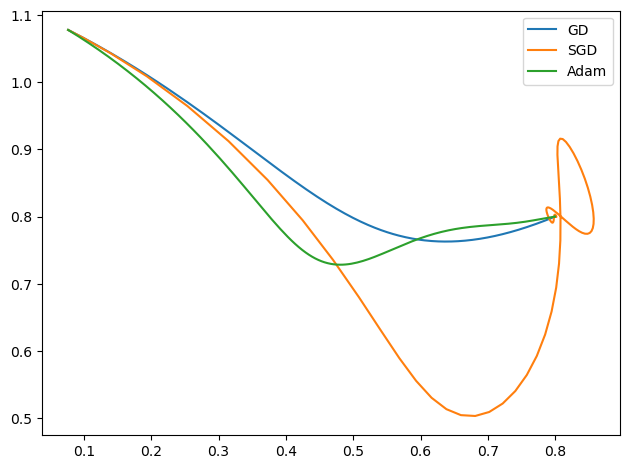

383
27
180


In [28]:
theta0 = np.array([2.5, -2.0])
target = np.array([0.8, 0.8])
hist_gd = gradient_descent(theta0, target, LENGTHS, learning_rate=0.01, n_iterations=500)
hist_sgd = SGD(theta0, target, LENGTHS, learning_rate=0.01, n_iterations=500)
hist_adam = Adam(theta0, target, LENGTHS, learning_rate=0.01, n_iterations=500)

plt.figure()
plt.plot(hist_gd[2][:, 0], hist_gd[2][:, 1], label=f"GD")
plt.plot(hist_sgd[2][:, 0], hist_sgd[2][:, 1], label=f"SGD")
plt.plot(hist_adam[2][:, 0], hist_adam[2][:, 1], label=f"Adam")
plt.legend()
plt.tight_layout()
plt.show()

print(hist_gd[3])
print(hist_sgd[4])
print(hist_adam[4])



In [ ]:
# Run animation
ani = animate_robot(hist_adam[0])

HTML(ani.to_jshtml())

<div class="alert alert-info">
Q8: Start the arm at $θ = [2.5, -2.0]$ trying to reach target ($0.8, 0.8$). Compare how many iterations GD ($η=0.01$), Momentum ($β=0.9, η=0.01$), and Adam (default parameters) each need to get within distance $0.01$ of the target. Report the iteration counts and explain the ranking.
</div>

<div class="alert alert-info">
Q9: For the Adam optimizer on the same task, plot the effective per-parameter learning rate ($η_eff = η * m̂_t / (√v̂_t + ε)$) for both $θ₁$ and $θ₂$ over time. Do they receive the same effective learning rate throughout optimization? Explain why this adaptive behavior is useful.</div>

## Part 3: Gradient-Free Optimization

For this exercise, implement a basic gradient-free algorithm, specifically an evolutionary strategy. Evolution Strategies are a class of gradient-free optimization algorithms inspired by natural evolution. Unlike gradient-based methods that require computing derivatives, ES samples multiple candidate solutions (a "population") around the current solution, evaluates their fitness (objective function value), and moves toward the direction indicated by the better-performing samples. Use the following rules for your ES:

For iteration $t$, with current parameter vector $\theta_t$:
$$
\begin{align}
\epsilon_i &\sim \mathcal{N}(0, I) \quad \text{for } i = 1, \ldots, N \\
\theta_i &= \theta_t + \sigma \epsilon_i \\
F_i &= -L(\theta_i) \quad \text{(fitness = negative loss)} \\
\theta_{t+1} &= \theta_t + \alpha \frac{1}{N} \sum_{i=1}^{N} F_i \epsilon_i
\end{align}
$$

where $N$ is the population size, $\sigma$ is the exploration noise (standard deviation), $\alpha$ is the learning rate, and $\epsilon_i$ are the perturbation vectors.

<div class="alert alert-info">
    Q10: Run this ES with population sizes $P = [10, 20, 50]$. For each, report: (a) does it reach the target successfully? (b) how many iterations does it take? (c) total number of function evaluations ($P$ × iterations). What trend do you observe with increasing population size?</div>

In [90]:
def gradient_free_optim(theta_init: np.ndarray, 
                     target: np.ndarray,
                     lengths: np.ndarray,
                     learning_rate: float = 0.01,
                     n_iterations: int = 500,
                     pop_size: int = 10,
                     lambda_obs: float = 10.0) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    # Convert to JAX arrays
    theta = jnp.array(theta_init)
    lengths_jax = jnp.array(lengths)
    target_jax = jnp.array(target)
    reach_iter = np.inf
    

    loss_fn = lambda th: loss_target_reaching(th, lengths_jax, target_jax)
    grad_fn = grad_loss_target

    # Storage for history
    theta_history = np.zeros((n_iterations + 1, 2))
    loss_history = np.zeros(n_iterations + 1)
    ee_trajectory = np.zeros((n_iterations + 1, 2))
    
    # Initial values
    theta_history[0] = np.array(theta)
    loss_history[0] = float(loss_fn(theta))
    ee_trajectory[0] = np.array(forward_kinematics_jax(theta, lengths_jax))
    # Optimization loop
    for i in range(n_iterations):
        noise = jax.random.normal(jax.random.PRNGKey(i), (pop_size, 2))*0.1
        theta_pop = theta + noise
        losses = jnp.array([loss_fn(th) for th in theta_pop])
        weights = jax.nn.softmax(-losses/0.1)
        grad = jnp.sum(weights[:, None] * noise, axis=0)
        theta = theta + learning_rate * grad

        # Store history
        theta_history[i + 1] = np.array(theta)        
        loss_history[i + 1] = float(loss_fn(theta))        
        ee_trajectory[i + 1] = np.array(forward_kinematics_jax(theta, lengths_jax))
        if reach_iter > 1000:
            if np.sqrt(np.sum((ee_trajectory[i + 1] - target_jax)**2)) < 1e-2:
                reach_iter = i + 1
        
    return theta_history, loss_history, ee_trajectory, reach_iter


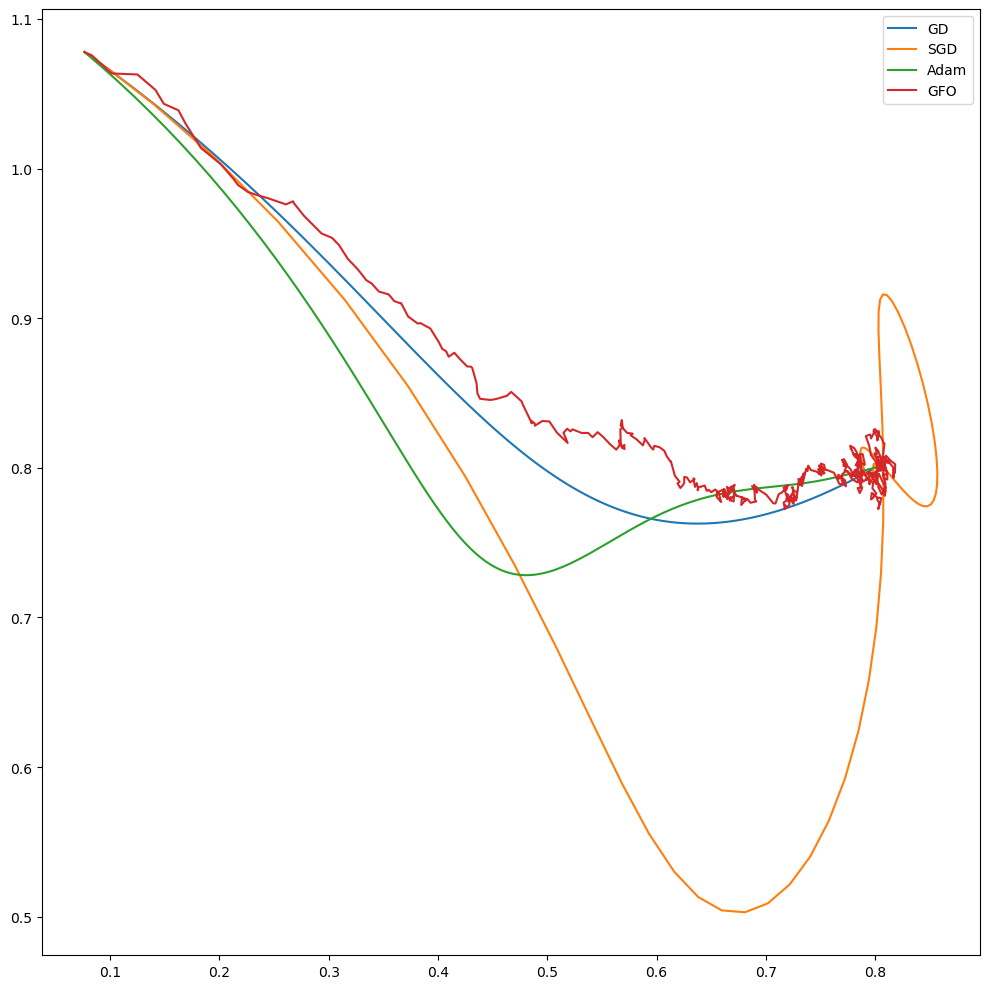

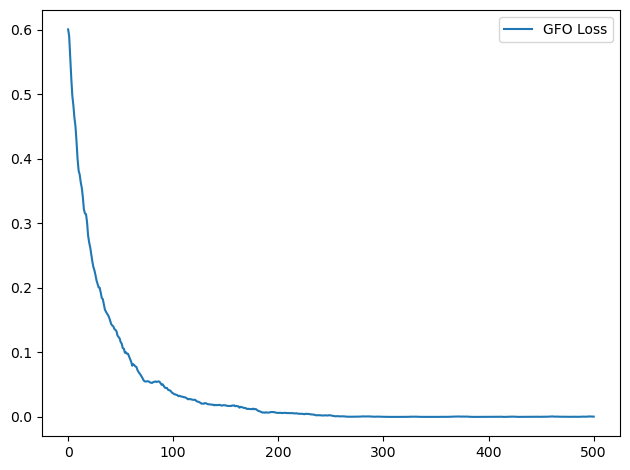

383
27
180
302


In [91]:
theta0 = np.array([2.5, -2.0])
target = np.array([0.8, 0.8])
hist_gd = gradient_descent(theta0, target, LENGTHS, learning_rate=0.01, n_iterations=500)
hist_sgd = SGD(theta0, target, LENGTHS, learning_rate=0.01, n_iterations=500)
hist_adam = Adam(theta0, target, LENGTHS, learning_rate=0.01, n_iterations=500)
hist_gfo = gradient_free_optim(theta0, target, LENGTHS, learning_rate=0.1, n_iterations=500)

plt.figure(figsize=(10,10))
plt.plot(hist_gd[2][:, 0], hist_gd[2][:, 1], label=f"GD")
plt.plot(hist_sgd[2][:, 0], hist_sgd[2][:, 1], label=f"SGD")
plt.plot(hist_adam[2][:, 0], hist_adam[2][:, 1], label=f"Adam")
plt.plot(hist_gfo[2][:, 0], hist_gfo[2][:, 1], label=f"GFO")
plt.legend()
plt.tight_layout()
plt.show()

# Plot loss for gfo
plt.figure()
plt.plot(hist_gfo[1], label=f"GFO Loss")
plt.legend()
plt.tight_layout()
plt.show()

print(hist_gd[3])
print(hist_sgd[4])
print(hist_adam[4])
print(hist_gfo[3])


<div class="alert alert-info">
Q11: ES doesn't use gradients, so it evaluates the loss N times per iteration while SGD evaluates it once plus one gradient computation. For a successful run of each method, count total loss function evaluations. Which is more sample-efficient? Despite this, describe one scenario where ES might still be preferred over gradient-based methods.</div>

## Part 4: Trajectory Optimization - Optimizing Sequences

So far, we've only optimized the **final configuration** of the robot arm - finding joint angles that place the end-effector at the target. However, in real robotics, we often care about the **entire motion path**. A robot might reach the target, but if it does so with jerky, energy-intensive movements, the solution isn't practical.

In this section, you'll optimize a **trajectory** - a sequence of joint angles over time - to reach the target while minimizing energy consumption and ensuring smooth motion.

### Trajectory Representation

Instead of optimizing $\theta \in \mathbb{R}^2$, we now optimize:
$$\Theta = [\theta_0, \theta_1, \ldots, \theta_T] \in \mathbb{R}^{T \times 2}$$

where $T$ is the number of timesteps (e.g., $T=20$).

### Multi-Objective Loss Function

We balance three competing objectives:

$$L_{total}(\Theta) = L_{target} + \lambda_{energy} L_{energy} + \lambda_{smooth} L_{smooth}$$

where:
- **Target reaching**: $L_{target} = \|\text{pos}(\theta_T) - \text{target}\|^2$ (only final position matters)
- **Energy cost**: $L_{energy} = \sum_{t=1}^{T} \|\theta_t - \theta_{t-1}\|^2$ (penalize large joint movements)
- **Smoothness**: $L_{smooth} = \sum_{t=2}^{T} \|(\theta_t - \theta_{t-1}) - (\theta_{t-1} - \theta_{t-2})\|^2$ (penalize acceleration/jerkiness)

The hyperparameters $\lambda_{energy}$ and $\lambda_{smooth}$ control the trade-off between reaching the target quickly versus moving efficiently and smoothly.

In [164]:
# Trajectory Optimization Functions

def loss_trajectory(theta_sequence: jnp.ndarray, 
                   lengths: jnp.ndarray,
                   target: jnp.ndarray,
                   lambda_energy: float = 0.1,
                   lambda_smooth: float = 0.05) -> float:
    """
    Loss for trajectory optimization.
    
    Parameters:
    -----------
    theta_sequence : jnp.ndarray, shape (T, 2)
        Sequence of joint angles over T timesteps
    lengths : jnp.ndarray, shape (2,)
        Link lengths
    target : jnp.ndarray, shape (2,)
        Target position
    lambda_energy : float
        Weight for energy cost
    lambda_smooth : float
        Weight for smoothness cost
    
    Returns:
    --------
    loss : float
        Total loss combining target reaching, energy, and smoothness
    """
    T = theta_sequence.shape[0]
    
    # Target reaching: only final position matters
    final_pos = forward_kinematics_jax(theta_sequence[-1], lengths)
    loss_target = jnp.sum((final_pos - target) ** 2)

    # Start keeping
    start_pos = forward_kinematics_jax(theta_sequence[0], lengths)
    loss_start = jnp.sum((start_pos - jnp.array([0.1, 0.1])) ** 2)
    
    # Energy cost: sum of squared velocities (joint movements)
    velocities = theta_sequence[1:] - theta_sequence[:-1]  # Shape: (T-1, 2)
    loss_energy = jnp.sum(velocities ** 2)
    
    # Smoothness cost: sum of squared accelerations
    accelerations = velocities[1:] - velocities[:-1]  # Shape: (T-2, 2)
    loss_smooth = jnp.sum(accelerations ** 2)
    
    return loss_target + lambda_energy * loss_energy + lambda_smooth * loss_smooth #+ loss_start


# Create gradient function for trajectory optimization
grad_loss_trajectory = jit(grad(loss_trajectory, argnums=0))

In [95]:
def plot_trajectory_sequence(theta_sequence: np.ndarray,
                             lengths: np.ndarray,
                             target: np.ndarray = None,
                             title: str = "Arm Trajectory Over Time"):
    """
    Visualize the robot arm at multiple points along the trajectory.
    
    Parameters:
    -----------
    theta_sequence : np.ndarray, shape (T, 2)
        Sequence of joint angles
    lengths : np.ndarray
        Link lengths
    target : np.ndarray, optional
        Target position
    title : str
        Plot title
    """
    fig, ax = plt.subplots()
    
    T = len(theta_sequence)
    colors = plt.cm.viridis(np.linspace(0, 1, T))
    
    # Plot each arm configuration
    for t in range(0, T, max(1, T//10)):  # Show ~10 frames
        points = get_arm_points(theta_sequence[t], lengths)
        alpha = 0.3 + 0.7 * (t / T)  # Fade from transparent to opaque
        ax.plot(points[:, 0], points[:, 1], 'o-', 
               color=colors[t], alpha=alpha, linewidth=2, markersize=4)
    
    # Plot final configuration more prominently
    points_final = get_arm_points(theta_sequence[-1], lengths)
    ax.plot(points_final[:, 0], points_final[:, 1], 'o-', 
           color='red', linewidth=3, markersize=8, label='Final')
    
    # Plot end-effector trajectory
    ee_traj = np.array([forward_kinematics_numpy(theta_sequence[t], lengths) 
                        for t in range(T)])
    ax.plot(ee_traj[:, 0], ee_traj[:, 1], 'b--', 
           linewidth=2, alpha=0.5, label='End-effector path')
    
    # Plot target
    if target is not None:
        ax.plot(target[0], target[1], 'g*', markersize=20, label='Target')
    
    # Plot base
    ax.plot(0, 0, 'ks', markersize=12, label='Base')
    
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-2.5, 2.5)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(title)
    ax.legend()
    
    return fig, ax

In [96]:
def analyze_trajectory_metrics(theta_sequence: np.ndarray):
    """
    Compute and print trajectory quality metrics.
    
    Parameters:
    -----------
    theta_sequence : np.ndarray, shape (T, 2)
        Sequence of joint angles
    """
    velocities = np.diff(theta_sequence, axis=0)
    accelerations = np.diff(velocities, axis=0)
    
    # Compute metrics
    total_movement = np.sum(np.abs(velocities))
    max_velocity = np.max(np.linalg.norm(velocities, axis=1))
    max_acceleration = np.max(np.linalg.norm(accelerations, axis=1))
    smoothness = np.sum(accelerations ** 2)  # Lower is smoother
    
    print("Trajectory Metrics:")
    print(f"  Total joint movement: {total_movement:.4f} radians")
    print(f"  Max velocity: {max_velocity:.4f} rad/timestep")
    print(f"  Max acceleration: {max_acceleration:.4f} rad/timestep²")
    print(f"  Smoothness cost: {smoothness:.4f} (lower is better)")

In [159]:
# Test trajectory optimization with gradient descent
def gradient_descent_trajectory(theta_init: np.ndarray,
                               target: np.ndarray,
                               lengths: np.ndarray,
                               T: int = 20,
                               learning_rate: float = 0.01,
                               n_iterations: int = 1000,
                               lambda_energy: float = 0.1,
                               lambda_smooth: float = 0.05):
    # Initialize trajectory: linear interpolation from init to a guess
    target_angles = theta_init + 0.5  # Simple guess for final angles
    theta_sequence = jnp.array([
        theta_init + (target_angles - theta_init) * t / (T - 1)
        for t in range(T)
    ])

    
    lengths_jax = jnp.array(lengths)
    target_jax = jnp.array(target)
    
    loss_history = []
    
    for iteration in range(n_iterations):
        # Compute loss and gradient
        loss_val = loss_trajectory(theta_sequence, lengths_jax, target_jax,
                                   lambda_energy, lambda_smooth)
        gradient = grad_loss_trajectory(theta_sequence, lengths_jax, target_jax,
                                       lambda_energy, lambda_smooth)
        
        # Update trajectory
        theta_sequence = theta_sequence - learning_rate * gradient
        
        loss_history.append(float(loss_val))
        
        if iteration % 100 == 0:
            print(f"Iteration {iteration}: Loss = {loss_val:.6f}")
    
    return np.array(theta_sequence), np.array(loss_history)

In [98]:
def sgd_momentum_trajectory(theta_init: np.ndarray,
                                target: np.ndarray,
                                lengths: np.ndarray,
                                T: int = 20,
                                learning_rate: float = 0.01,
                                beta: float = 0.9,
                                n_iterations: int = 1000,
                                lambda_energy: float = 0.1,
                                lambda_smooth: float = 0.05):
    # Initialize trajectory: linear interpolation from init to a guess
    target_angles = theta_init + 0.5  # Simple guess for final angles
    theta_sequence = jnp.array([
        theta_init + (target_angles - theta_init) * t / (T - 1)
        for t in range(T)
    ])
    
    lengths_jax = jnp.array(lengths)
    target_jax = jnp.array(target)
    v = jnp.zeros_like(theta_sequence)
    
    loss_history = []
    
    for iteration in range(n_iterations):
        # Compute loss and gradient
        loss_val = loss_trajectory(theta_sequence, lengths_jax, target_jax,
                                   lambda_energy, lambda_smooth)
        gradient = grad_loss_trajectory(theta_sequence, lengths_jax, target_jax,
                                       lambda_energy, lambda_smooth)
        
        # Update trajectory
        v = beta * v + gradient
        theta_sequence = theta_sequence - learning_rate * v
        
        loss_history.append(float(loss_val))
        
        if iteration % 100 == 0:
            print(f"Iteration {iteration}: Loss = {loss_val:.6f}")
    
    return np.array(theta_sequence), np.array(loss_history)

In [130]:
def adam_trajectory(theta_init: np.ndarray,
                                target: np.ndarray,
                                lengths: np.ndarray,
                                T: int = 20,
                                learning_rate: float = 0.01,
                                beta1: float = 0.9,
                                beta2: float = 0.999,
                                n_iterations: int = 1000,
                                lambda_energy: float = 0.1,
                                lambda_smooth: float = 0.05):
    # Initialize trajectory: linear interpolation from init to a guess
    target_angles = theta_init + 0.5  # Simple guess for final angles
    theta_sequence = jnp.array([
        theta_init + (target_angles - theta_init) * t / (T - 1)
        for t in range(T)
    ])
    
    lengths_jax = jnp.array(lengths)
    target_jax = jnp.array(target)
    v = jnp.zeros_like(theta_sequence)
    m = jnp.zeros_like(theta_sequence)
    
    loss_history = []
    
    for i in range(n_iterations):
        # Compute loss and gradient
        loss_val = loss_trajectory(theta_sequence, lengths_jax, target_jax,
                                   lambda_energy, lambda_smooth)
        gradient = grad_loss_trajectory(theta_sequence, lengths_jax, target_jax,
                                       lambda_energy, lambda_smooth)
        
        # Update trajectory
        m = beta1 * m + (1 - beta1) * gradient
        v = beta2 * v + (1 - beta2) * gradient**2
        m_hat = m / (1 - beta1**(i + 1))
        v_hat = v / (1 - beta2**(i + 1))
        # TODO: Update 
        # theta using gradient descent rule
        # theta = ?
        theta_sequence = theta_sequence - learning_rate * m_hat / (jnp.sqrt(v_hat) + 1e-8)
        
        loss_history.append(float(loss_val))
        
        if i % 100 == 0:
            print(f"Iteration {i}: Loss = {loss_val:.6f}")
    
    return np.array(theta_sequence), np.array(loss_history)

Testing Trajectory Optimization

Optimizing trajectory with T=20 timesteps
Initial configuration: [0.1 0.1]
Target position: [1.  1.5]

Iteration 0: Loss = 3.593165
Iteration 100: Loss = 2.942307
Iteration 200: Loss = 1.072468
Iteration 300: Loss = 0.563516
Iteration 400: Loss = 0.442266
Iteration 500: Loss = 0.379136
Iteration 600: Loss = 0.337680
Iteration 700: Loss = 0.307583
Iteration 800: Loss = 0.284387
Iteration 900: Loss = 0.265774
Iteration 1000: Loss = 0.250395
Iteration 1100: Loss = 0.237400
Iteration 1200: Loss = 0.226227
Iteration 1300: Loss = 0.216482
Iteration 1400: Loss = 0.207882
Iteration 1500: Loss = 0.200219
Iteration 1600: Loss = 0.193331
Iteration 1700: Loss = 0.187095
Iteration 1800: Loss = 0.181415
Iteration 1900: Loss = 0.176212


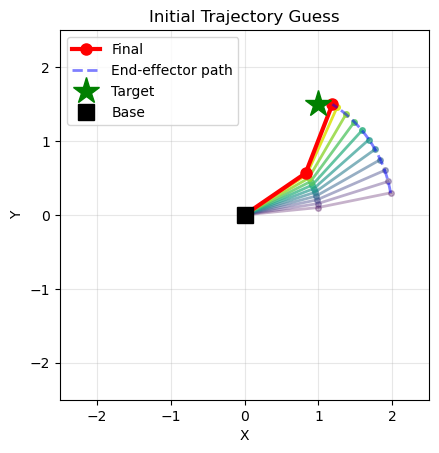

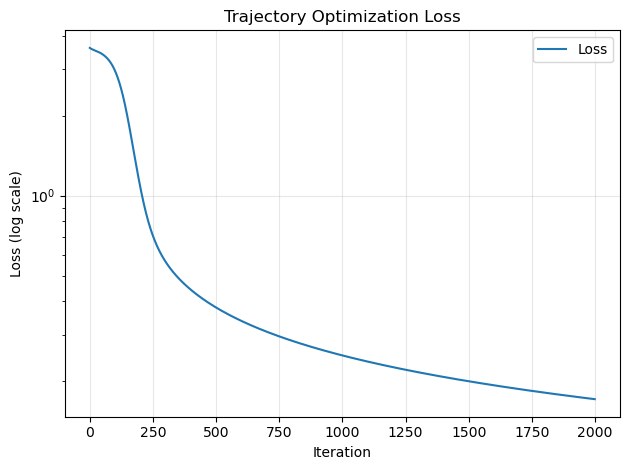

In [158]:
# Example usage
print("="*60)
print("Testing Trajectory Optimization")
print("="*60)

theta_init = np.array([0.1, 0.1])
target = np.array([1.0, 1.5])
T = 20

print(f"\nOptimizing trajectory with T={T} timesteps")
print(f"Initial configuration: {theta_init}")
print(f"Target position: {target}\n")

theta_traj, loss_hist = gradient_descent_trajectory(
    theta_init, target, LENGTHS,
    T=T, learning_rate=0.01, n_iterations=2000,
    lambda_energy=0.1, lambda_smooth=0.05
)

# Visualize results
plot_loss_curve(loss_hist, "Trajectory Optimization Loss")
plt.show()

In [101]:
def plot_loss_curve(loss_history: np.ndarray, title: str = "Trajectory Optimization Loss Over Iterations"):
    """
    Plot the loss curve over iterations.
    
    Parameters:
    -----------
    loss_history : np.ndarray
        Array of loss values over iterations
    title : str
        Plot title
    """
    plt.figure()
    plt.plot(loss_history, label='Loss')
    plt.yscale('log')
    plt.xlabel('Iteration')
    plt.ylabel('Loss (log scale)')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

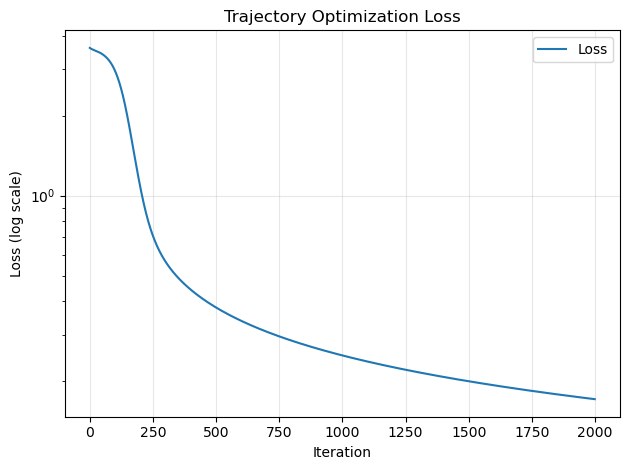

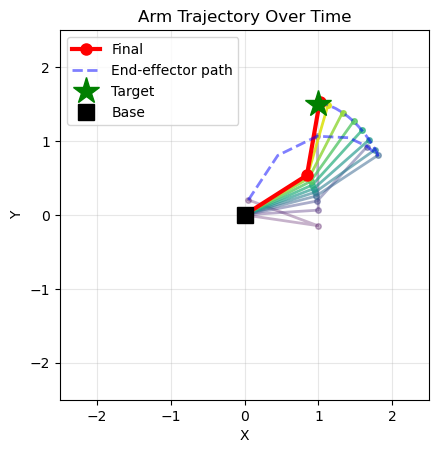

Trajectory Metrics:
  Total joint movement: 3.8852 radians
  Max velocity: 0.7562 rad/timestep
  Max acceleration: 0.1621 rad/timestep²
  Smoothness cost: 0.0967 (lower is better)


In [160]:
# Visualize results
plot_loss_curve(loss_hist, "Trajectory Optimization Loss")
plt.show()

plot_trajectory_sequence(theta_traj, LENGTHS, target)
plt.show()

analyze_trajectory_metrics(theta_traj)

Q12: Run trajectory optimization with three different energy weights: $\lambda_{energy} = [0.01, 0.1, 1.0]$ (keep $\lambda_{smooth}=0.05$ fixed). For each, visualize the resulting trajectory and report the total joint movement (sum of velocity magnitudes). How does increasing the energy penalty affect the motion? Does the arm still reach the target?


Testing Trajectory Optimization

Optimizing trajectory with T=20 timesteps
Initial configuration: [0.1 0.1]
Target position: [1.  1.5]

Using lambda_energy = 0.01
Iteration 0: Loss = 0.035503
Iteration 100: Loss = 0.007561
Iteration 200: Loss = 0.005755
Iteration 300: Loss = 0.004471
Iteration 400: Loss = 0.003555
Iteration 500: Loss = 0.002902
Iteration 600: Loss = 0.002436
Iteration 700: Loss = 0.002100
Iteration 800: Loss = 0.001854
Iteration 900: Loss = 0.001671
Iteration 1000: Loss = 0.001532
Iteration 1100: Loss = 0.001425
Iteration 1200: Loss = 0.001340
Iteration 1300: Loss = 0.001271
Iteration 1400: Loss = 0.001214
Iteration 1500: Loss = 0.001167
Iteration 1600: Loss = 0.001126
Iteration 1700: Loss = 0.001091
Iteration 1800: Loss = 0.001061
Iteration 1900: Loss = 0.001034
Iteration 2000: Loss = 0.001010
Iteration 2100: Loss = 0.000988
Iteration 2200: Loss = 0.000969
Iteration 2300: Loss = 0.000951
Iteration 2400: Loss = 0.000935
Iteration 2500: Loss = 0.000920
Iteration 2600: L

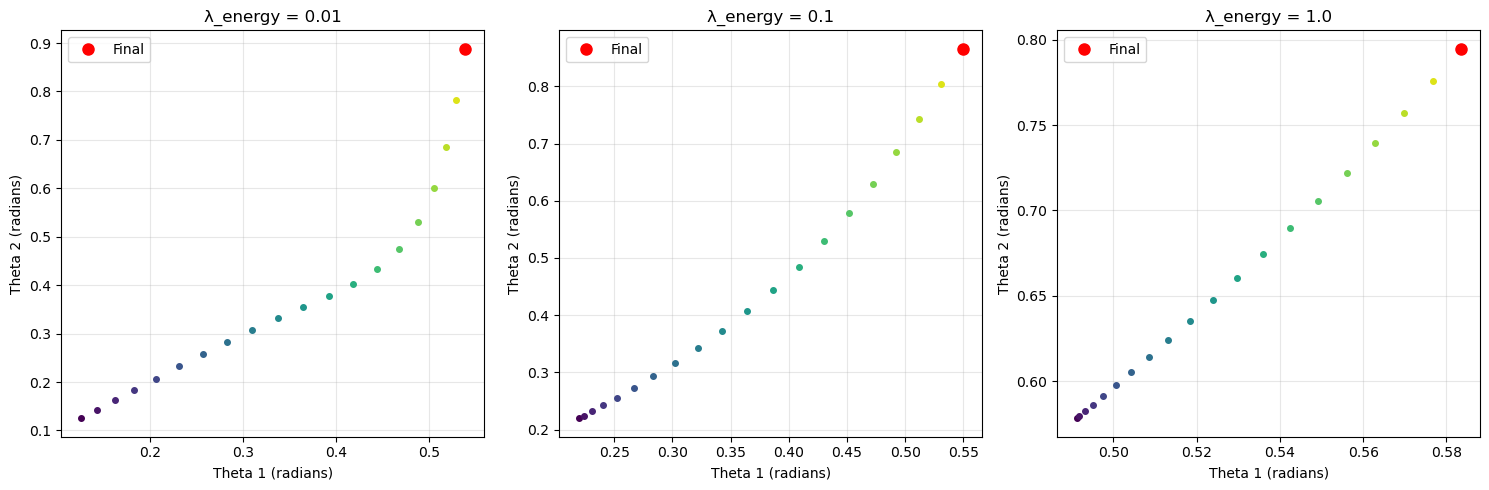

In [103]:
# Example usage
print("="*60)
print("Testing Trajectory Optimization")
print("="*60)

theta_init = np.array([0.1, 0.1])
target = np.array([1.0, 1.5])
T = 20

print(f"\nOptimizing trajectory with T={T} timesteps")
print(f"Initial configuration: {theta_init}")
print(f"Target position: {target}\n")

lambda_energy_list = [0.01, 0.1, 1.0]

# for lambda_energy in lambda_energy_list:
#     print(f"Using lambda_energy = {lambda_energy}")
#     theta_traj, loss_hist = gradient_descent_trajectory(
#         theta_init, target, LENGTHS,
#         T=T, learning_rate=0.01, n_iterations=1000,
#         lambda_energy=lambda_energy, lambda_smooth=0.05
#     )
#     # Visualize results
#     plot_loss_curve(loss_hist, "Trajectory Optimization Loss")
#     plt.show()

#     plot_trajectory_sequence(theta_traj, LENGTHS, target)
#     plt.show()

#     analyze_trajectory_metrics(theta_traj)

# Plot trajectories side by side
fig, axes = plt.subplots(1, len(lambda_energy_list), figsize=(15, 5))
for i, lambda_energy in enumerate(lambda_energy_list):
    print(f"Using lambda_energy = {lambda_energy}")
    theta_traj, loss_hist = gradient_descent_trajectory(
        theta_init, target, LENGTHS,
        T=T, learning_rate=0.01, n_iterations=1000,
        lambda_energy=lambda_energy, lambda_smooth=0.05
    )
    print(f"end_effector position: {forward_kinematics_numpy(theta_traj[-1], LENGTHS)}")
    # Visualize results
    plt.sca(axes[i])
    plt.title(f"λ_energy = {lambda_energy}")
    T = len(theta_traj)
    colors = plt.cm.viridis(np.linspace(0, 1, T))

    for t in range(T):
        plt.plot(theta_traj[t, 0], theta_traj[t, 1], 'o', color=colors[t], markersize=4)
    plt.plot(theta_traj[-1, 0], theta_traj[-1, 1], 'ro', markersize=8, label='Final')
    plt.xlabel('Theta 1 (radians)')
    plt.ylabel('Theta 2 (radians)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
plt.show()


Using optimizer: lambda=0.01
Iteration 0: Loss = 0.035503
Iteration 100: Loss = 0.007561
Iteration 200: Loss = 0.005755
Iteration 300: Loss = 0.004471
Iteration 400: Loss = 0.003555
Iteration 500: Loss = 0.002902
Iteration 600: Loss = 0.002436
Iteration 700: Loss = 0.002100
Iteration 800: Loss = 0.001854
Iteration 900: Loss = 0.001671
Trajectory Metrics:
  Total joint movement: 1.2012 radians
  Max velocity: 0.1691 rad/timestep
  Max acceleration: 0.0592 rad/timestep²
  Smoothness cost: 0.0079 (lower is better)
Using optimizer: lambda=0.1
Iteration 0: Loss = 0.037871
Iteration 100: Loss = 0.011086
Iteration 200: Loss = 0.009691
Iteration 300: Loss = 0.008755
Iteration 400: Loss = 0.008082
Iteration 500: Loss = 0.007578
Iteration 600: Loss = 0.007187
Iteration 700: Loss = 0.006876
Iteration 800: Loss = 0.006623
Iteration 900: Loss = 0.006412
Trajectory Metrics:
  Total joint movement: 1.1252 radians
  Max velocity: 0.1116 rad/timestep
  Max acceleration: 0.0265 rad/timestep²
  Smoothnes

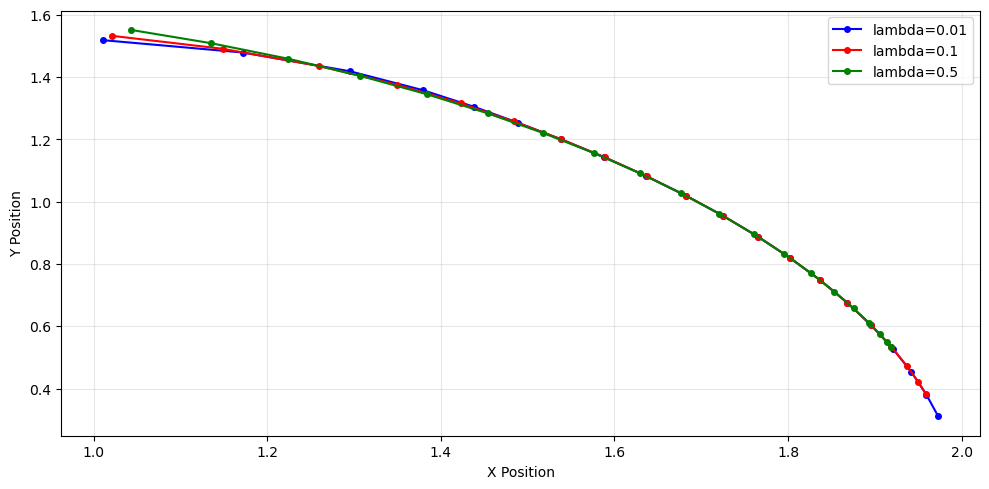

In [110]:
# Plot trajectories side by side
plt.figure(figsize=(10, 5))
lambda_energy_list = [0.01, 0.1, 0.5]
titles = ["lambda=0.01", "lambda=0.1", "lambda=0.5"]  
T = 20
for i, lam in enumerate(lambda_energy_list):
    print(f"Using optimizer: {titles[i]}")
    theta_traj, loss_hist = gradient_descent_trajectory(
        theta_init, target, LENGTHS,
        T=T, learning_rate=0.01, n_iterations=1000,
        lambda_energy=lam, lambda_smooth=0.05
    )
    analyze_trajectory_metrics(theta_traj)
    end_effector_traj = np.array([forward_kinematics_numpy(theta_traj[t], LENGTHS) for t in range(len(theta_traj))])
    # Visualize results
    T_len = len(theta_traj)
    colors = ['blue', 'red', 'green']

    plt.plot(end_effector_traj[:, 0], end_effector_traj[:, 1], 'o', color=colors[i], markersize=4, linestyle='-', label=titles[i])
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Q13: Compare trajectory optimization using SGD with Momentum vs Adam. Use $T=20$, $\lambda_{energy}=0.1$, $\lambda_{smooth}=0.05$. Which converges faster? Plot both trajectories side-by-side. Do they find qualitatively different solutions (different motion strategies)?

Testing Trajectory Optimization

Optimizing trajectory with T=20 timesteps
Initial configuration: [0.1 0.1]
Target position: [1.  1.5]

Iteration 0: Loss = 3.593165
Iteration 100: Loss = 0.074191
Iteration 200: Loss = 0.044161
Iteration 300: Loss = 0.034203
Iteration 400: Loss = 0.030738
Iteration 500: Loss = 0.029517
Iteration 600: Loss = 0.029077
Iteration 700: Loss = 0.028916
Iteration 800: Loss = 0.028854
Iteration 900: Loss = 0.028830


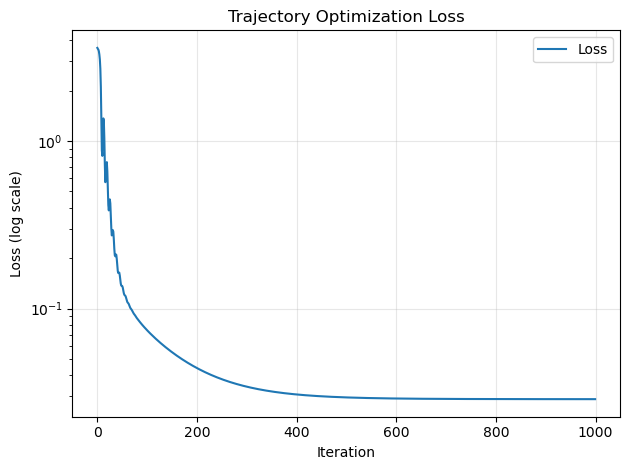

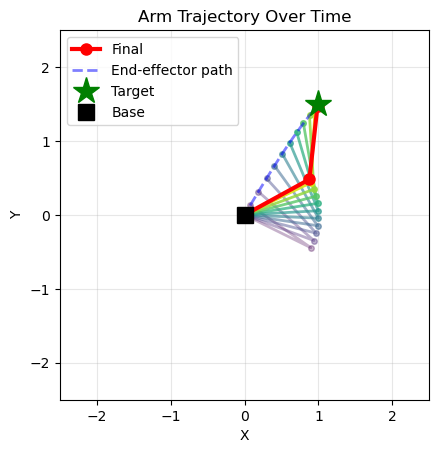

Trajectory Metrics:
  Total joint movement: 2.9935 radians
  Max velocity: 0.1205 rad/timestep
  Max acceleration: 0.0004 rad/timestep²
  Smoothness cost: 0.0000 (lower is better)


In [161]:
# Example usage
print("="*60)
print("Testing Trajectory Optimization")
print("="*60)

theta_init = np.array([0.1, 0.1])
target = np.array([1.0, 1.5])
T = 20

print(f"\nOptimizing trajectory with T={T} timesteps")
print(f"Initial configuration: {theta_init}")
print(f"Target position: {target}\n")

theta_traj, loss_hist = sgd_momentum_trajectory(
    theta_init, target, LENGTHS,
    T=T, learning_rate=0.1, n_iterations=1000,
    lambda_energy=0.1, lambda_smooth=0.05
)

# Visualize results
plot_loss_curve(loss_hist, "Trajectory Optimization Loss")
plt.show()

plot_trajectory_sequence(theta_traj, LENGTHS, target)
plt.show()

analyze_trajectory_metrics(theta_traj)

Testing Trajectory Optimization

Optimizing trajectory with T=20 timesteps
Initial configuration: [0.1 0.1]
Target position: [1.  1.5]

Iteration 0: Loss = 0.037871
Iteration 100: Loss = 0.002304
Iteration 200: Loss = 0.000531
Iteration 300: Loss = 0.000076
Iteration 400: Loss = 0.000007
Iteration 500: Loss = 0.000000
Iteration 600: Loss = 0.000000
Iteration 700: Loss = 0.000000
Iteration 800: Loss = 0.000000
Iteration 900: Loss = 0.000000


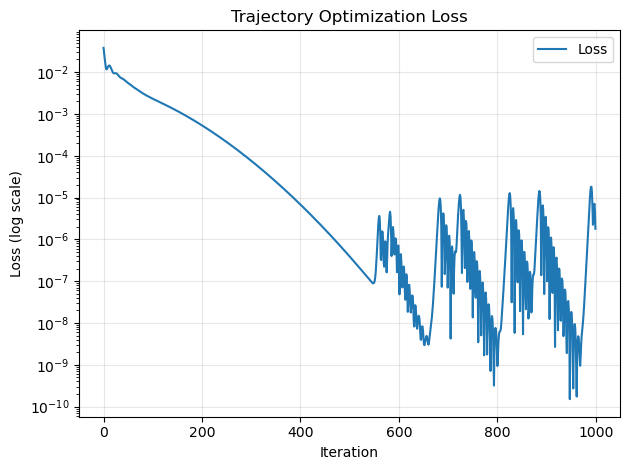

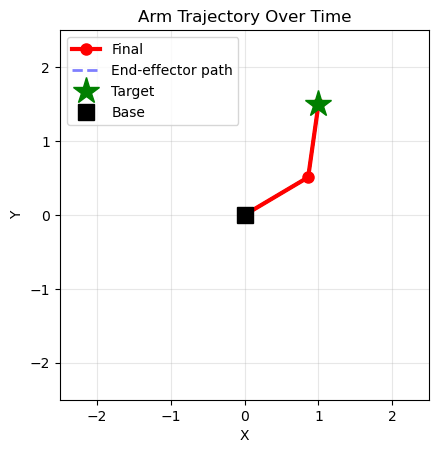

Trajectory Metrics:
  Total joint movement: 0.0059 radians
  Max velocity: 0.0011 rad/timestep
  Max acceleration: 0.0020 rad/timestep²
  Smoothness cost: 0.0000 (lower is better)


In [165]:
# Example usage
print("="*60)
print("Testing Trajectory Optimization")
print("="*60)

theta_init = np.array([0.1, 0.1])
target = np.array([1.0, 1.5])
T = 20

print(f"\nOptimizing trajectory with T={T} timesteps")
print(f"Initial configuration: {theta_init}")
print(f"Target position: {target}\n")

theta_traj, loss_hist = adam_trajectory(
    theta_init, target, LENGTHS,
    T=T, learning_rate=0.01, n_iterations=1000,
    lambda_energy=0.1, lambda_smooth=0.05
)

# Visualize results
plot_loss_curve(loss_hist, "Trajectory Optimization Loss")
plt.show()

plot_trajectory_sequence(theta_traj, LENGTHS, target)
plt.show()

analyze_trajectory_metrics(theta_traj)

Using optimizer: Gradient Descent
Iteration 0: Loss = 0.037871
Iteration 100: Loss = 0.017281
Iteration 200: Loss = 0.013609
Iteration 300: Loss = 0.012753
Iteration 400: Loss = 0.012385
Iteration 500: Loss = 0.012118
Iteration 600: Loss = 0.011882
Iteration 700: Loss = 0.011664
Iteration 800: Loss = 0.011460
Iteration 900: Loss = 0.011269
Trajectory Metrics:
  Total joint movement: 1.1103 radians
  Max velocity: 0.1043 rad/timestep
  Max acceleration: 0.0487 rad/timestep²
  Smoothness cost: 0.0028 (lower is better)
Using optimizer: SGD with Momentum
Iteration 0: Loss = 0.037871
Iteration 100: Loss = 0.011207
Iteration 200: Loss = 0.009756
Iteration 300: Loss = 0.008795
Iteration 400: Loss = 0.008109
Iteration 500: Loss = 0.007596
Iteration 600: Loss = 0.007201
Iteration 700: Loss = 0.006887
Iteration 800: Loss = 0.006631
Iteration 900: Loss = 0.006419
Trajectory Metrics:
  Total joint movement: 1.1254 radians
  Max velocity: 0.1118 rad/timestep
  Max acceleration: 0.0267 rad/timestep²

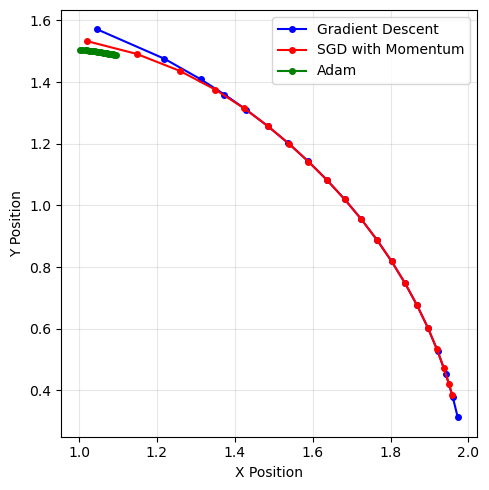

In [129]:
# Plot trajectories side by side
plt.figure(figsize=(5, 5))
optimizers = [gradient_descent_trajectory, sgd_momentum_trajectory, adam_trajectory]
titles = ['Gradient Descent', 'SGD with Momentum', 'Adam']  
T = 20
for i, optim_func in enumerate(optimizers):
    print(f"Using optimizer: {titles[i]}")
    theta_traj, loss_hist = optim_func(
        theta_init, target, LENGTHS,
        T=T, learning_rate=0.001, n_iterations=1000,
        lambda_energy=0.1, lambda_smooth=0.05
    )
    analyze_trajectory_metrics(theta_traj)
    end_effector_traj = np.array([forward_kinematics_numpy(theta_traj[t], LENGTHS) for t in range(len(theta_traj))])
    # Visualize results
    T_len = len(theta_traj)
    colors = ['blue', 'red', 'green']

    plt.plot(end_effector_traj[:, 0], end_effector_traj[:, 1], 'o', color=colors[i], markersize=4, linestyle='-', label=titles[i])
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Q14: The trajectory optimization problem has $T \times 2$ parameters (40 parameters for $T=20$). This is similar to optimizing a small neural network. Based on your experiments, which optimizer (GD, Momentum, Adam) would you recommend for optimizing trajectories? How might your answer change if $T=100$ (200 parameters)?


Q15: Gradient-free methods can also optimize trajectories! However, with $T \times 2$ parameters, the search space becomes much larger. Implement ES for trajectory optimization. Use a smaller population size initially (N=10) and $T=10$ timesteps to keep computation manageable. Compare sample efficiency (total function evaluations) with Adam. When might ES be preferred despite being less sample-efficient?
